
# Student Performance Factors: End-to-End Pipeline

This notebook consolidates the project workflow into a single, reproducible pipeline aligned with the main report. Run top-to-bottom to reproduce results.


In [2]:

# Core setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    r2_score, mean_squared_error, accuracy_score, confusion_matrix,
    precision_score, recall_score, f1_score, roc_curve, auc, classification_report, silhouette_score
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

np.random.seed(42)
_ = tf.random.set_seed(42)

DATA_PATH = Path('..') / 'data' / 'Cleaned_StudentPerformanceFactors.csv'
assert DATA_PATH.exists(), f"Missing dataset at {DATA_PATH}"

sns.set_theme(style="whitegrid")
plt.rcParams.update({"figure.figsize": (8, 5), "axes.titlesize": 13, "axes.labelsize": 11})


2025-12-05 16:56:59.471306: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-05 16:56:59.503529: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-05 16:57:00.325662: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.



## 1. Data Loading & Cleaning
- Load the cleaned dataset used across check-ins.
- Verify missingness; impute as before (mode for categoricals, median for numerics) for reproducibility.
- Keep outliers (educational context) after IQR inspection.


In [3]:

# Load data
raw_df = pd.read_csv(DATA_PATH)
print(f"Raw shape: {raw_df.shape[0]:,} rows x {raw_df.shape[1]} columns")
raw_df.head()


Raw shape: 6,378 rows x 20 columns


,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


In [4]:

# Missing value summary
missing = raw_df.isnull().sum()
missing_df = pd.DataFrame({"missing": missing, "pct": (missing / len(raw_df) * 100).round(2)})
print(missing_df[missing_df['missing'] > 0])


Empty DataFrame
Columns: [missing, pct]
Index: []


In [5]:

# Impute using mode (categorical) and median (numeric) to match earlier cleaning
clean_df = raw_df.copy()
cat_cols = clean_df.select_dtypes(include=['object']).columns
num_cols = clean_df.select_dtypes(exclude=['object']).columns

for col in cat_cols:
    if clean_df[col].isnull().any():
        clean_df[col].fillna(clean_df[col].mode()[0], inplace=True)
for col in num_cols:
    if clean_df[col].isnull().any():
        clean_df[col].fillna(clean_df[col].median(), inplace=True)

print(f"Post-imputation missing values: {clean_df.isnull().sum().sum()}")


Post-imputation missing values: 0


In [6]:

# Quick IQR outlier check (no removal)
outlier_summary = []
for col in num_cols:
    q1, q3 = clean_df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    outliers = ((clean_df[col] < lower) | (clean_df[col] > upper)).sum()
    outlier_summary.append((col, outliers))

pd.DataFrame(outlier_summary, columns=['feature', 'outlier_count']).sort_values('outlier_count', ascending=False).head(5)


,feature,outlier_count
4,Tutoring_Sessions,423
6,Exam_Score,103
0,Hours_Studied,40
2,Sleep_Hours,0
1,Attendance,0



## 2. Exploratory Data Analysis (highlights)
- Distribution of `Exam_Score`.
- Correlation of top numeric predictors with `Exam_Score`.


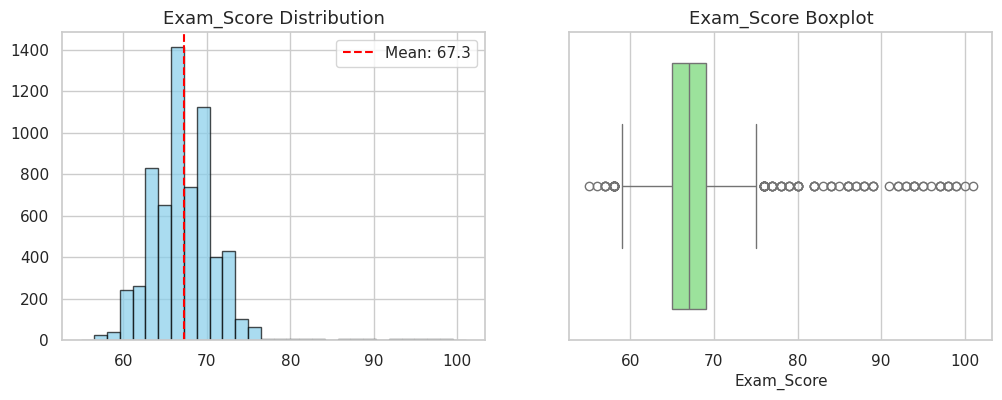

In [7]:

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(clean_df['Exam_Score'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].axvline(clean_df['Exam_Score'].mean(), color='red', linestyle='--', label=f"Mean: {clean_df['Exam_Score'].mean():.1f}")
axes[0].set_title('Exam_Score Distribution')
axes[0].legend()

sns.boxplot(x=clean_df['Exam_Score'], ax=axes[1], color='lightgreen')
axes[1].set_title('Exam_Score Boxplot')
plt.show()


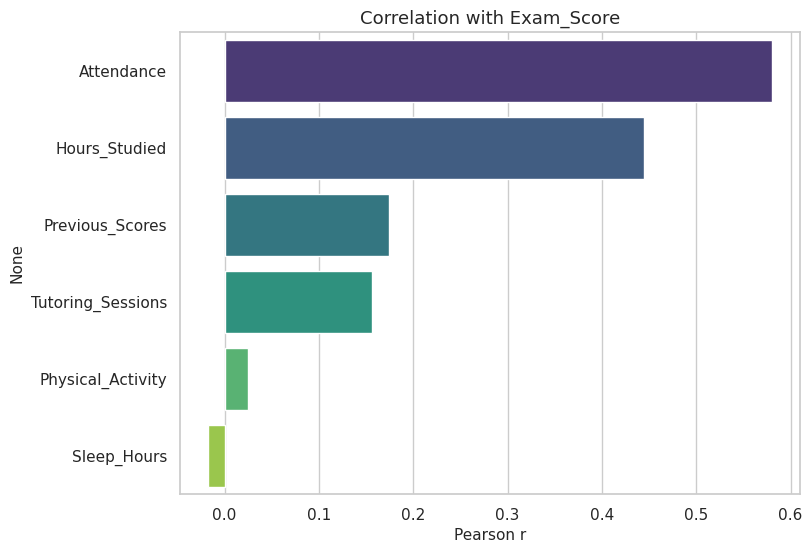

Attendance           0.580259
Hours_Studied        0.445104
Previous_Scores      0.174283
Tutoring_Sessions    0.156829
Physical_Activity    0.025148
Name: Exam_Score, dtype: float64

In [8]:

# Correlation heatmap for numeric features
numeric_features = clean_df.select_dtypes(include=[np.number]).columns.tolist()
corr = clean_df[numeric_features].corr()['Exam_Score'].drop('Exam_Score').sort_values(key=np.abs, ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=corr.values, y=corr.index, palette='viridis')
plt.title('Correlation with Exam_Score')
plt.xlabel('Pearson r')
plt.show()

corr.head(5)



## 3. Regression Baseline and Regularization
Simple linear regression using `Attendance` as in prior check-ins, plus Ridge/Lasso comparison.


In [9]:

# Train/validation split
X_reg = clean_df[['Attendance']]
y_reg = clean_df['Exam_Score']

X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)

lin_reg = LinearRegression()
lin_reg.fit(X_train_reg, y_train_reg)

# Predictions
y_train_pred = lin_reg.predict(X_train_reg)
y_val_pred = lin_reg.predict(X_val_reg)

r2_train = r2_score(y_train_reg, y_train_pred)
r2_val = r2_score(y_val_reg, y_val_pred)
mse_train = mean_squared_error(y_train_reg, y_train_pred)
mse_val = mean_squared_error(y_val_reg, y_val_pred)

print(f"Linear Regression R2 train: {r2_train:.4f}, val: {r2_val:.4f}")
print(f"MSE train: {mse_train:.4f}, val: {mse_val:.4f}")


Linear Regression R2 train: 0.3266, val: 0.3601
MSE train: 10.3211, val: 9.7906


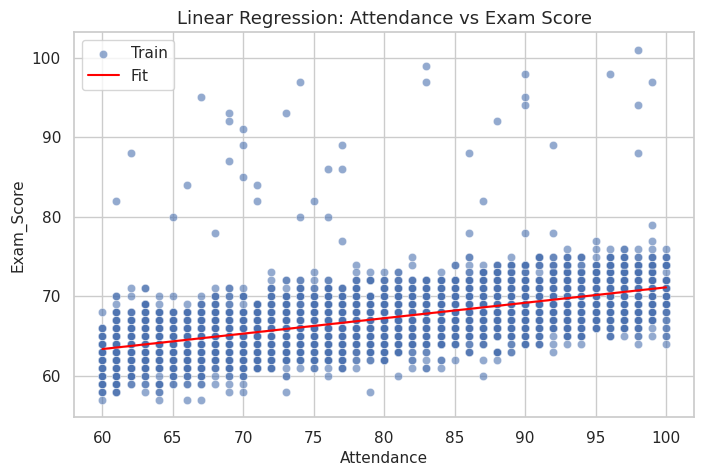

In [10]:

# Plot training fit
plt.figure(figsize=(8,5))
sns.scatterplot(x=X_train_reg['Attendance'], y=y_train_reg, label='Train', alpha=0.6)
sns.lineplot(x=X_train_reg['Attendance'], y=y_train_pred, color='red', label='Fit')
plt.title('Linear Regression: Attendance vs Exam Score')
plt.xlabel('Attendance')
plt.ylabel('Exam_Score')
plt.show()


In [ ]:

# Ridge and Lasso (same single feature for parity with prior check-in)
ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=1.0)

ridge.fit(X_train_reg, y_train_reg)
lasso.fit(X_train_reg, y_train_reg)

for name, model in [('Ridge', ridge), ('Lasso', lasso)]:
    y_pred_train = model.predict(X_train_reg)
    y_pred_val = model.predict(X_val_reg)
    print(f"{name} R2 train: {r2_score(y_train_reg, y_pred_train):.4f}, val: {r2_score(y_val_reg, y_pred_val):.4f}")
    print(f"{name} MSE train: {mean_squared_error(y_train_reg, y_pred_train):.4f}, val: {mean_squared_error(y_val_reg, y_pred_val):.4f}")


SyntaxError: unterminated f-string literal (detected at line 12) (1769910342.py, line 12)


## 4. Logistic Regression (School_Type)
Binary target `School_Type` (Public vs Private). Feature selection via point-biserial correlation; standardized logistic regression; ROC and 5-fold CV.


In [ ]:

# Encode binary target
log_df = clean_df.copy()
log_df['School_Type_Binary'] = (log_df['School_Type'] == 'Public').astype(int)

# Numeric features excluding targets
num_feats = log_df.select_dtypes(include=[np.number]).columns.tolist()
for drop_col in ['Exam_Score', 'School_Type_Binary']:
    if drop_col in num_feats:
        num_feats.remove(drop_col)

# Point-biserial correlations
corrs = {}
for col in num_feats:
    corrs[col] = np.corrcoef(log_df[col], log_df['School_Type_Binary'])[0,1]

corr_series = pd.Series(corrs).dropna().abs().sort_values(ascending=False)
selected_features = corr_series.head(2).index.tolist()
print("Selected features:", selected_features)


In [ ]:

X_log = log_df[selected_features]
y_log = log_df['School_Type_Binary']

X_train_log, X_val_log, y_train_log, y_val_log = train_test_split(
    X_log, y_log, test_size=0.3, random_state=42, stratify=y_log
)

scaler = StandardScaler()
X_train_log_scaled = scaler.fit_transform(X_train_log)
X_val_log_scaled = scaler.transform(X_val_log)

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_log_scaled, y_train_log)

# Train metrics
train_preds = log_reg.predict(X_train_log_scaled)
train_proba = log_reg.predict_proba(X_train_log_scaled)[:,1]

val_preds = log_reg.predict(X_val_log_scaled)
val_proba = log_reg.predict_proba(X_val_log_scaled)[:,1]

for split, y_true, preds, proba in [('Train', y_train_log, train_preds, train_proba), ('Val', y_val_log, val_preds, val_proba)]:
    cm = confusion_matrix(y_true, preds)
    tn, fp, fn, tp = cm.ravel()
    acc = accuracy_score(y_true, preds)
    prec = precision_score(y_true, preds)
    rec = recall_score(y_true, preds)
    f1 = f1_score(y_true, preds)
    print(f"{split} - Acc: {acc:.3f}, Prec: {prec:.3f}, Rec: {rec:.3f}, F1: {f1:.3f}")


In [ ]:

# ROC curve (validation)
fpr, tpr, thresholds = roc_curve(y_val_log, val_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, label=f'ROC (AUC={roc_auc:.3f})', linewidth=2)
plt.plot([0,1],[0,1],'r--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC (Validation)')
plt.legend()
plt.show()


In [ ]:

# 5-fold stratified CV with scaler inside pipeline to avoid leakage
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
log_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(max_iter=1000, random_state=42))
])

cv_auc = cross_val_score(
    log_pipe,
    X_log,
    y_log,
    cv=skf,
    scoring='roc_auc'
)
print("CV AUC scores:", cv_auc)
print(f"Mean AUC: {cv_auc.mean():.3f} (+/- {cv_auc.std():.3f})")



## 5. KNN Classification (HighScore)
Target: `HighScore` = 1 if `Exam_Score` ≥ 67 (as in prior check-in). Evaluate best k via grid search; report confusion matrix, ROC, 5-fold CV.


In [ ]:

knn_df = clean_df.copy()
knn_df['HighScore'] = (knn_df['Exam_Score'] >= 67).astype(int)
features_knn = ['Hours_Studied', 'Attendance', 'Previous_Scores']

X_knn = knn_df[features_knn]
y_knn = knn_df['HighScore']

X_train_knn, X_val_knn, y_train_knn, y_val_knn = train_test_split(
    X_knn, y_knn, test_size=0.3, random_state=42, stratify=y_knn
)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

param_grid = {'knn__n_neighbors': list(range(1, 21))}
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_knn, y_train_knn)

best_knn = grid.best_estimator_
print(f"Best k: {grid.best_params_['knn__n_neighbors']}, CV accuracy: {grid.best_score_:.3f}")


In [ ]:

# Validation performance
y_val_pred = best_knn.predict(X_val_knn)
y_val_proba = best_knn.predict_proba(X_val_knn)[:,1]

cm = confusion_matrix(y_val_knn, y_val_pred)
(tn, fp, fn, tp) = cm.ravel()
acc = accuracy_score(y_val_knn, y_val_pred)
prec = precision_score(y_val_knn, y_val_pred)
rec = recall_score(y_val_knn, y_val_pred)
f1 = f1_score(y_val_knn, y_val_pred)

print(f"Confusion Matrix:
{cm}")
print(f"Acc: {acc:.3f}, Prec: {prec:.3f}, Rec: {rec:.3f}, F1: {f1:.3f}")


In [ ]:

# ROC curve
fpr, tpr, _ = roc_curve(y_val_knn, y_val_proba)
roc_auc_knn = auc(fpr, tpr)

plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, label=f'KNN ROC (AUC={roc_auc_knn:.3f})', linewidth=2)
plt.plot([0,1],[0,1],'r--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('KNN ROC (Validation)')
plt.show()


In [ ]:

# 5-fold CV on validation split to mirror check-in
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_knn, X_val_knn, y_val_knn, cv=skf, scoring='accuracy')
print("CV accuracy on validation split:", cv_scores)
print(f"Mean: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")



## 6. Unsupervised: KMeans (+ optional PCA view)
Replicates clustering check-in: elbow & silhouette over k=2–8, pick k=3, summarize clusters and relation to high exam scores.


In [ ]:

cluster_df = clean_df.copy()
num_cols_cluster = cluster_df.select_dtypes(include=[np.number]).columns.tolist()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_df[num_cols_cluster])

inertias, silhouettes, k_values = [], [], range(2, 9)
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].plot(list(k_values), inertias, marker='o')
axes[0].set_xlabel('k')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Plot')

axes[1].plot(list(k_values), silhouettes, marker='o', color='orange')
axes[1].set_xlabel('k')
axes[1].set_ylabel('Silhouette')
axes[1].set_title('Silhouette Scores')
plt.show()


In [ ]:

best_k = 3
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)
cluster_df['Cluster'] = cluster_labels

cluster_summary = cluster_df.groupby('Cluster')[num_cols_cluster].mean().round(2)
cluster_summary.head()


In [ ]:

# High exam score rate by cluster
threshold = cluster_df['Exam_Score'].median()
cluster_df['High_Exam'] = (cluster_df['Exam_Score'] >= threshold).astype(int)

crosstab = pd.crosstab(cluster_df['Cluster'], cluster_df['High_Exam'], normalize='index').round(2)
print("High exam rate by cluster (rows sum to 1):")
print(crosstab)


In [ ]:

# PCA 2D visualization
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=coords[:,0], y=coords[:,1], hue=cluster_labels, palette='tab10', alpha=0.6)
plt.title('KMeans Clusters (PCA 2D)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.show()



## 7. Neural Network Regression (Exam_Score)
Two hidden-layer MLP (128, 64) mirroring the sixth check-in; one-hot encode categoricals, scale numerics; report MSE/MAE/R² and prediction scatter.


In [ ]:

# Preprocess: one-hot categoricals + scale numerics
cat_cols_nn = clean_df.select_dtypes(include=['object']).columns.tolist()
num_cols_nn = clean_df.select_dtypes(exclude=['object']).columns.tolist()
num_cols_nn.remove('Exam_Score')

y_nn = clean_df['Exam_Score']
X_nn = clean_df.drop(columns=['Exam_Score'])

preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols_nn),
    ('num', StandardScaler(), num_cols_nn)
])

X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(
    X_nn, y_nn, test_size=0.2, random_state=42
)

# Fit transformer and convert to arrays
X_train_prep = preprocess.fit_transform(X_train_nn)
X_test_prep = preprocess.transform(X_test_nn)
input_dim = X_train_prep.shape[1]

model = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])


In [ ]:

history = model.fit(
    X_train_prep, y_train_nn,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)


In [ ]:

# Evaluation
loss, mae = model.evaluate(X_test_prep, y_test_nn, verbose=0)
preds = model.predict(X_test_prep).flatten()

r2_nn = r2_score(y_test_nn, preds)
mse_nn = mean_squared_error(y_test_nn, preds)
print(f"Test MSE: {mse_nn:.4f}, MAE: {mae:.4f}, R2: {r2_nn:.4f}")


In [ ]:

# Loss curves
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()


In [ ]:

# Predictions vs actual
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_test_nn, y=preds, alpha=0.6)
plt.plot([y_test_nn.min(), y_test_nn.max()], [y_test_nn.min(), y_test_nn.max()], 'r--')
plt.xlabel('Actual Exam_Score')
plt.ylabel('Predicted Exam_Score')
plt.title('NN Predictions vs Actuals')
plt.show()



## 8. How to Run
- Install dependencies: `python -m venv .venv && source .venv/bin/activate && pip install -r requirements.txt`
- From repo root: `jupyter notebook notebooks/07_main_pipeline.ipynb` and run all cells.
- Data: expects `data/Cleaned_StudentPerformanceFactors.csv` (read-only). Outputs are inline plots; derived tables can be exported as needed.
